In [178]:
from datetime import datetime

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from_beginning = '1987-01-01'
# hang seng index start: 1987-01-01
name = '^HSI'

today = datetime.now()
last_10_years = f'{today.year - 9}-01-01'
last_20_years = f'{today.year - 19}-01-01'
last_30_years = f'{today.year - 29}-01-01'
start_date = f'1900-01-01'
choices = [last_10_years, last_20_years, last_30_years, start_date]

start_date = from_beginning
hsi = yf.download('^HSI', start=from_beginning)
hsi

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0
1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0
1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0
1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0
1987-01-08,2603.300049,2603.300049,2603.300049,2603.300049,2603.300049,0
...,...,...,...,...,...,...
2024-08-15,17008.210938,17283.650391,16926.470703,17109.140625,17109.140625,2407027500
2024-08-16,17286.039062,17473.890625,17255.859375,17430.160156,17430.160156,2551716800
2024-08-19,17569.660156,17685.859375,17547.650391,17569.570312,17569.570312,2361570600


Window Dressing: 
- Fund manager tends to long stocks with good performance at the end of the year to drive up their portfolio performance
- Hypothesis: The probability of a positive return should be higher in the last day of a year compared to a normal day

In [92]:
last_day = hsi.groupby(hsi.index.year).last()
sec_last_day = hsi.groupby(hsi.index.year).apply(lambda x : x.iloc[-2])

In [218]:
# last day close / second last day close
temp = (last_day['Close'] / sec_last_day['Close'] - 1)
temp.name = 'Return'
temp = temp.iloc[:-1]
p = temp[temp > 0].shape[0] / temp.shape[0]
print(f'Probability of positive return(close day pct_change) is: {round(p * 100, 2)}%')

Probability of positive return(close day pct_change) is: 60.0%


In [219]:
# normal day, day close / prev day close
temp = hsi['Close'].pct_change().dropna()
temp.name = 'Return'
p = temp[temp > 0].shape[0] / temp.shape[0]
print(f'Probability of positive return(close day pct_change) in a normal day is: {round(p * 100, 2)}%')

Probability of positive return(close day pct_change) in a normal day is: 51.68%


In [116]:
# last day return(close / last day open - 1)
temp = last_day['Close'] / last_day['Open'] - 1
temp.name = 'Return'
temp = temp.iloc[:-1]
p = temp[temp > 0].shape[0] / temp.shape[0]
print(f'Probability of positive return(close open pct_change) is: {round(p * 100, 2)}%')

Probability of positive return(close open pct_change) is: 51.35%


In [117]:
# normal day return(day close / day open - 1)
temp = hsi['Close'] / hsi['Open'] - 1
p = temp[temp > 0].shape[0] / temp.shape[0]
print(f'Probability of positive return(close open pct_change) in a normal day is: {round(p * 100, 2)}%')

Probability of positive return(close open pct_change) in a normal day is: 46.37%


Check end of year, end of month, end of quarter

In [214]:
def check_window_dressing(_df, group_by: str):
    if group_by.lower() == 'year' or group_by.lower() == 'y':
        _group_by = _df.index.year
    elif group_by.lower() == 'month' or group_by.lower() == 'm':
        _group_by = [_df.index.year, _df.index.month]
    elif group_by.lower() == 'quarterly' or group_by.lower() == 'q':
        _group_by = _df.index.to_period('Q')
    else:
        raise ValueError('group_by must be in the form: year, month, quarterly | y, m, q')
    
    _last_day = _df.groupby(_group_by).last()
    _sec_last_day = _df.groupby(_group_by).apply(lambda x : x.iloc[-2])
    
    _remove_last_days = []
    for __df in _df.groupby(_group_by):
        _remove_last_days.append(__df[1].iloc[-1].name)
    
    # normal day, day close / prev day close
    normal_df = _df['Close'].pct_change().fillna(0).loc[~_df.index.isin(_remove_last_days)]
    normal_df.name = 'Return'
    _p = normal_df[normal_df > 0].shape[0] / normal_df.shape[0]
    print(f'Probability of positive return(close day pct_change) in a normal day is: {round(_p * 100, 2)}%')
    # print(normal_df.describe())
    
    # last day close / second last day close
    last_df = (_last_day['Close'] / _sec_last_day['Close'] - 1)
    last_df.name = 'Return'
    last_df = last_df.iloc[:-1]
    _p = last_df[last_df > 0].shape[0] / last_df.shape[0]
    print(f'Probability of positive return(close day pct_change) is: {round(_p * 100, 2)}%')
    # print(temp.describe())
    
    bins=np.histogram(
        np.hstack((last_df[(last_df > -0.1) & (last_df < 0.1)], 
        normal_df[(normal_df > -0.1) & (normal_df < 0.1)])), bins=40
    )[1]
    
    plt.hist(normal_df[(normal_df > -0.1) & (normal_df < 0.1)], bins=bins, density=True, label='Normal Day')
    plt.hist(last_df[(last_df > -0.1) & (last_df < 0.1)], bins=bins, density=True, label=f'Last Day ({group_by})')
    plt.axvline(x=0, color='black')
    plt.title(f'Distribution of Daily Returns, From {_df.index[0]}')
    plt.legend()
    plt.show()

Probability of positive return(close day pct_change) in a normal day is: 50.76%
Probability of positive return(close day pct_change) is: 88.89%


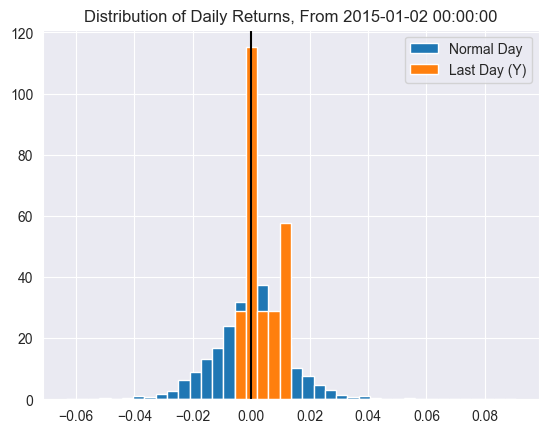

Probability of positive return(close day pct_change) in a normal day is: 51.7%
Probability of positive return(close day pct_change) is: 78.95%


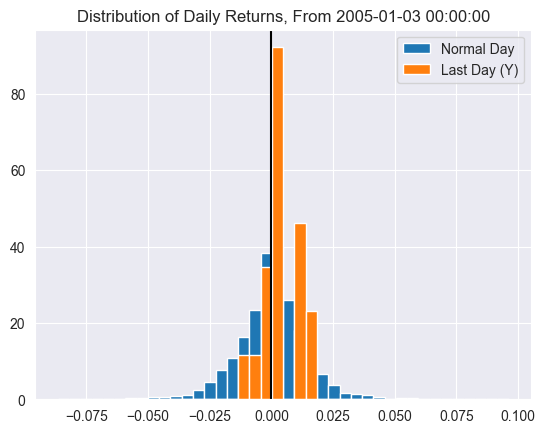

Probability of positive return(close day pct_change) in a normal day is: 51.2%
Probability of positive return(close day pct_change) is: 72.41%


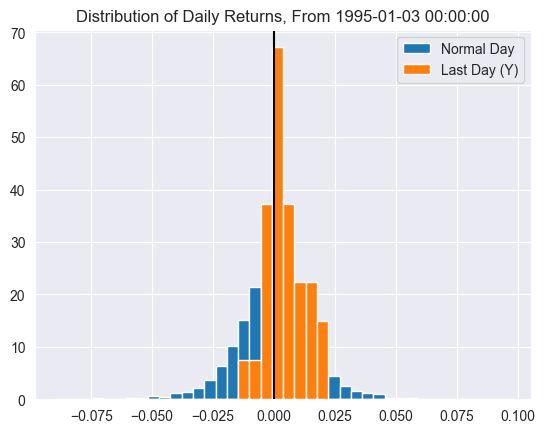

Probability of positive return(close day pct_change) in a normal day is: 51.62%
Probability of positive return(close day pct_change) is: 67.57%


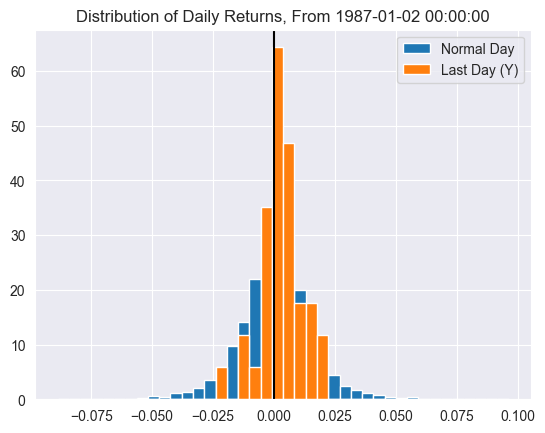

In [215]:
for period in choices:
    period_hsi = hsi[hsi.index >= period]
    check_window_dressing(period_hsi, group_by='Y')

Probability of positive return(close day pct_change) in a normal day is: 51.15%
Probability of positive return(close day pct_change) is: 46.09%


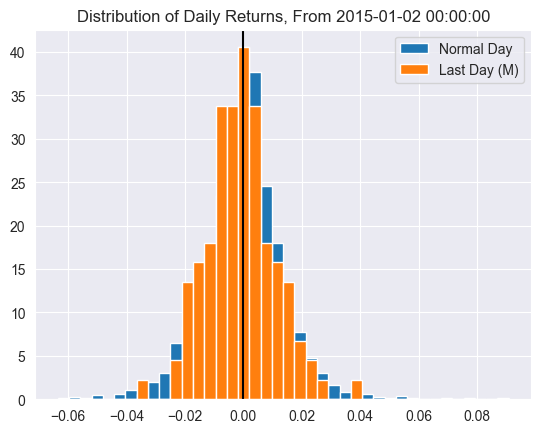

Probability of positive return(close day pct_change) in a normal day is: 51.91%
Probability of positive return(close day pct_change) is: 49.79%


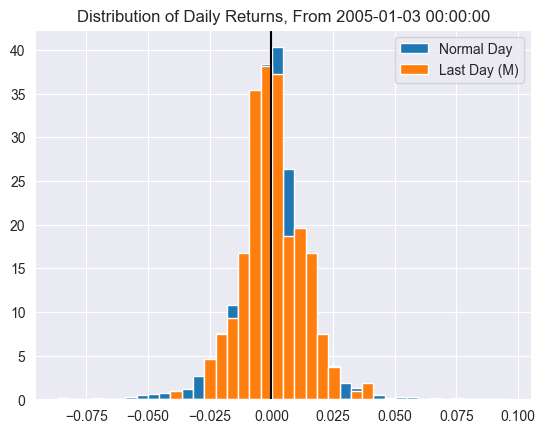

Probability of positive return(close day pct_change) in a normal day is: 51.15%
Probability of positive return(close day pct_change) is: 53.8%


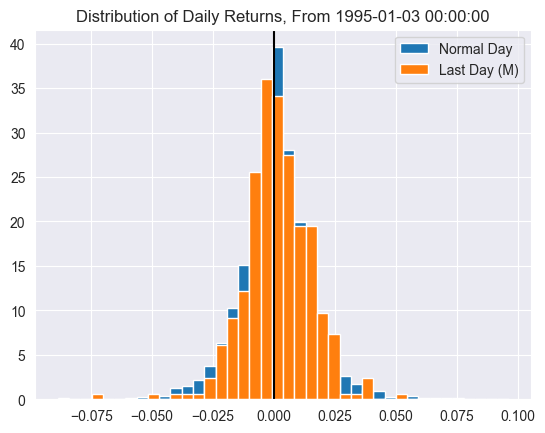

Probability of positive return(close day pct_change) in a normal day is: 51.44%
Probability of positive return(close day pct_change) is: 56.32%


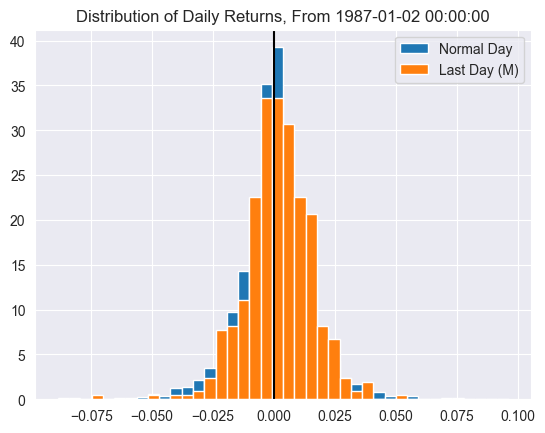

In [216]:
for period in choices:
    period_hsi = hsi[hsi.index >= period]
    check_window_dressing(period_hsi, group_by='M')

Probability of positive return(close day pct_change) in a normal day is: 50.62%
Probability of positive return(close day pct_change) is: 68.42%


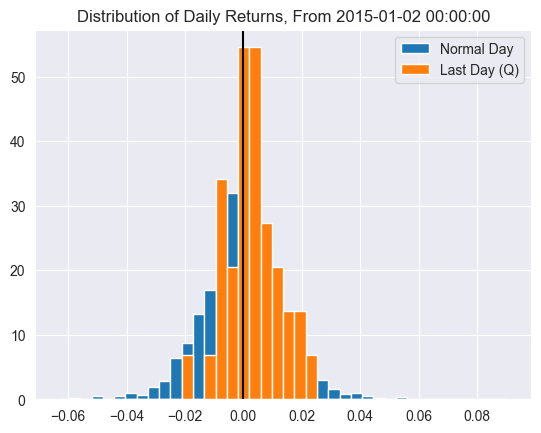

Probability of positive return(close day pct_change) in a normal day is: 51.69%
Probability of positive return(close day pct_change) is: 58.97%


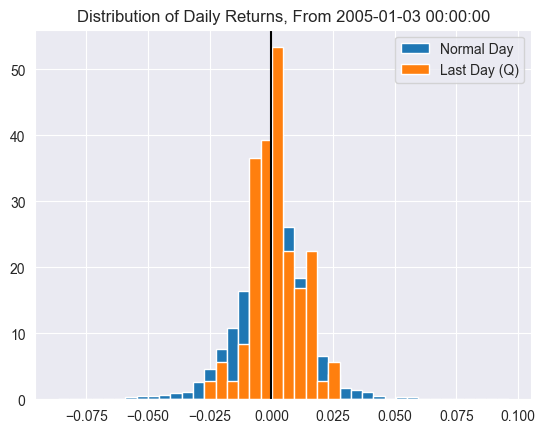

Probability of positive return(close day pct_change) in a normal day is: 51.12%
Probability of positive return(close day pct_change) is: 61.02%


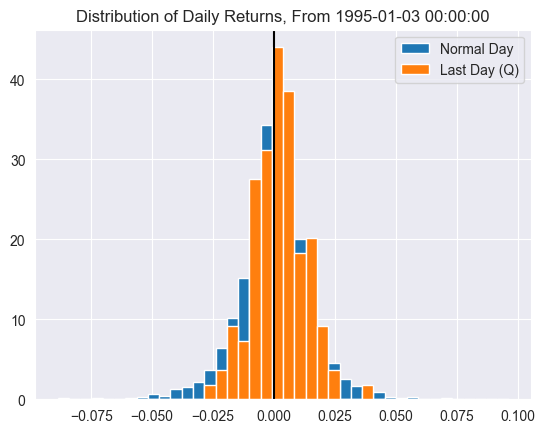

Probability of positive return(close day pct_change) in a normal day is: 51.54%
Probability of positive return(close day pct_change) is: 60.0%


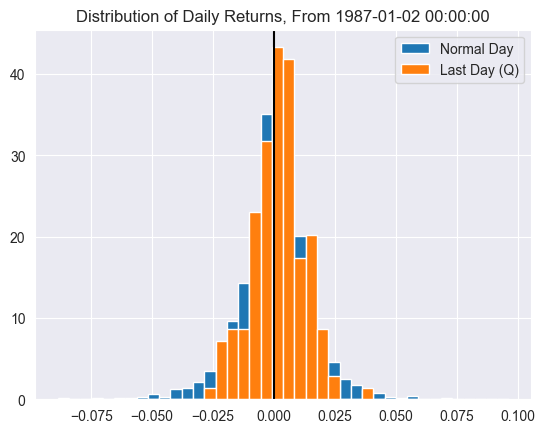

In [217]:
for period in choices:
    period_hsi = hsi[hsi.index >= period]
    check_window_dressing(period_hsi, group_by='Q')

See option expiry dates

In [222]:
day_be4_sec_last_day = hsi.groupby([hsi.index.year, hsi.index.month]).apply(lambda x : x.iloc[-3])
sec_last_day = hsi.groupby([hsi.index.year, hsi.index.month]).apply(lambda x : x.iloc[-2])

In [223]:
# last day close / second last day close
temp = (sec_last_day['Close'] / day_be4_sec_last_day['Close'] - 1)
temp.name = 'Return'
temp = temp.iloc[:-1]
p = temp[temp > 0].shape[0] / temp.shape[0]
print(f'Probability of positive return(close day pct_change) is: {round(p * 100, 2)}%')

Probability of positive return(close day pct_change) is: 48.56%


In [230]:
temp.index.names = ['Year', 'Month']
temp.reset_index().groupby('Month')['Return'].describe()

,count,mean,std,min,25%,50%,75%,max
Month,,,,,,,,
1,38.0,-0.002962,0.017082,-0.036905,-0.012358,-0.000927,0.007408,0.045779
2,38.0,0.001334,0.013771,-0.031796,-0.006942,0.002258,0.008933,0.031056
3,38.0,-0.000460,0.016601,-0.046968,-0.012000,0.001903,0.012562,0.027432
4,38.0,0.002326,0.010801,-0.019428,-0.003027,0.002338,0.007349,0.036654
5,38.0,-0.000919,0.013625,-0.022325,-0.009356,-0.003080,0.004022,0.052597
6,38.0,-0.003180,0.010945,-0.026136,-0.009332,-0.003843,0.004988,0.015660
7,38.0,0.001944,0.010305,-0.015253,-0.005429,0.000089,0.008427,0.033031
8,37.0,0.001524,0.013474,-0.042352,-0.007120,0.004631,0.008368,0.030588
9,37.0,-0.000590,0.013682,-0.042897,-0.006487,-0.001838,0.010434,0.024439
